## GOES Irradiance Corrections
[X]     First, convert x and y values to latitude and longitude

[X]     Then, downscale Channel 05 (1km res.) and 13 (2km res.) to the Channel 02 (0.5km res.) grid using linear interpolation.

[X]     Next, combine all bands to one dataset

[X]     To clip each band appropriately, we need to convert raw radiance values to reflectivity (channels 2 and 5) and brightness temperature (channel 13). Loosely based off of Brian Blaylock's goes2go

[X]     Now we can save our new, corrected RGB dataset as one zarr file for each day



In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Calculate latitude and longitude from GOES ABI fixed grid projection data
# GOES ABI fixed grid projection is a map projection relative to the GOES satellite
# Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
# See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculations
# "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library

# Clinton's note: I needed to change how attributes of the goes imager projection were accessed

def calculate_degrees(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.attrs['longitude_of_projection_origin']
    H = projection_info.attrs['perspective_point_height']+projection_info.attrs['semi_major_axis']
    r_eq = projection_info.attrs['semi_major_axis']
    r_pol = projection_info.attrs['semi_minor_axis']
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

In [11]:
# From goes2go - annoying warnings with import so copying here manually
def goes_norm(value, lower_limit, upper_limit, clip=True):
    """
    Normalize values between an upper and lower limit between 0 and 1.

    Normalize between a lower and upper limit. In other words, it
    converts your number to a value in the range between 0 and 1.
    Follows `normalization formula
    <https://stats.stackexchange.com/a/70807/220885>`_

    This is the same concept as `contrast or histogram stretching
    <https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20162017/LectureNotes/IP/PointOperators/ImageStretching.html>`_


    .. code:: python

        _normalizedValue = (OriginalValue-LowerLimit)/(UpperLimit-LowerLimit)

    Parameters
    ----------
    value :
        The original value. A single value, vector, or array.
    upper_limit :
        The upper limit.
    lower_limit :
        The lower limit.
    clip : bool
        - True: Clips values between 0 and 1 for RGB.
        - False: Retain the numbers that extends outside 0-1 range.
    """
    norm = (value - lower_limit) / (upper_limit - lower_limit)
    if clip:
        norm = np.clip(norm, 0, 1)
    return norm

def radiance_to_brightness_temp(ds, band):
    """
    Convert radiance to brightness temperature using the inverse Planck formula.

    ds: xarray.Dataset with radiance data

    band: str, the band number (e.g., '13' for channel 13)

    """
    # Constants
    c1 = 1.191042e-5    # W/m^2/sr/m^4
    c2 = 1.4387752      # cm*K

    # Wavelength in meters for the specified band
    channel_dict = {'13':10.4e-4}
    wavelength = channel_dict[band] # cm
    wavenumber = 1 / wavelength     # cm^-1

    radiance = ds[f'Rad_C{band}']

    # Calculate brightness temperature
    ds[f'btemp_C{band}'] = c2 * wavenumber / np.log((c1 * wavenumber**3) / radiance + 1)

    return ds

def downscale_goes_bands(path, date=False):
    """
    Downscale GOES-16 bands C02, C05, and C13 to the same grid and interpolate to match the target dataset.
    The function also calculates reflectivity and brightness temperature for the specified bands.

    Parameters
    ----------
    path : str
        Path to the directory containing the GOES-16 data files.
    date : str, optional
        Date string in the format 'YYYYMMDD'. For my convinience, my storage path stays unchanged
        
    """

    # Load the GOES-16 ABI data
    if date:
        path = '/storage/cdalden/goes/goes16/'
    file = f'goes16_C02_colorado_{date}.zarr'
    ds_C02 = xr.open_dataset(path+'channel02/'+file)
    file = f'goes16_C05_colorado_{date}.zarr'
    ds_C05 = xr.open_dataset(path+'channel05/'+file)
    file = f'goes16_C13_colorado_{date}.zarr'
    ds_C13 = xr.open_dataset(path+'channel13/'+file)

    # convert to lat and lon from x and y coordinates
    lat_C02, lon_C02 = calculate_degrees(ds_C02)
    lat_C05, lon_C05 = calculate_degrees(ds_C05)
    lat_C13, lon_C13 = calculate_degrees(ds_C13)
    ds_C02 = ds_C02.assign_coords(y=("y", lat_C02[:,0]), x=("x", lon_C02[0,:]))
    ds_C05 = ds_C05.assign_coords(y=("y", lat_C05[:,0]), x=("x", lon_C05[0,:]))
    ds_C13 = ds_C13.assign_coords(y=("y", lat_C13[:,0]), x=("x", lon_C13[0,:]))

    # Extract time coordinates from ds_C02
    time_C02 = ds_C02['t']
    ds_C13 = ds_C13.assign_coords(t=time_C02)
    ds_C05 = ds_C05.assign_coords(t=time_C02)

    # Ensure the coordinate ranges overlap
    target_lat = ds_C02['y']
    target_lon = ds_C02['x']

    # Align the coordinates of ds_C13 with ds_C02
    ds_C13_aligned = ds_C13.reindex_like(ds_C02, method='nearest')
    ds_C05_aligned = ds_C05.reindex_like(ds_C02, method='nearest')

    # Interpolate the source dataset to the target dataset's grid using a specified method
    ds_C13_resampled = ds_C13_aligned.interp(y=target_lat, x=target_lon, method='linear')
    ds_C05_resampled = ds_C05_aligned.interp(y=target_lat, x=target_lon, method='linear')
    # If there are still NaNs, try filling them with a method like nearest neighbor
    ds_C13_resampled_filled = ds_C13_resampled.fillna(ds_C13_aligned.interp(y=target_lat, x=target_lon, method='nearest'))
    ds_C05_resampled_filled = ds_C05_resampled.fillna(ds_C05_aligned.interp(y=target_lat, x=target_lon, method='nearest'))

    # Create a new dataset with the two Rad variables
    combined_ds = xr.Dataset(
        {'Rad_C13': ds_C13_resampled_filled['Rad'], 'Rad_C02': ds_C02['Rad'], 'Rad_C05': ds_C05_resampled_filled['Rad']},
        coords={'y': target_lat, 'x': target_lon, 't': ds_C02['t']})
    
    # reflectivity = kappa factor * radiance
    combined_ds['refl_C02'] = ds_C02['kappa0'] * combined_ds['Rad_C02']
    combined_ds['refl_C05'] = ds_C05['kappa0'] * combined_ds['Rad_C05']

    # Convert radiance to brightness temperature
    radiance_to_brightness_temp(combined_ds, '13')

    return combined_ds

def goes_clip_normalize(ds):

    ds['green'] = goes_norm(ds['refl_C02'], 0, 0.78, clip=True)
    ds['blue'] = goes_norm(ds['refl_C05'], 0.01, 0.59, clip=True)
    ds['red'] = goes_norm(ds['btemp_C13'], 219.65, 280.65, clip=True) # -53.5C to 7.5C

    return ds


In [12]:
date = '20230204'

In [13]:
ds = downscale_goes_bands(date)

/home/cdalden/miniforge3/envs/goes_old/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [ ]:
final_ds = goes_clip_normalize(ds)
# drop the original variables
final_ds = final_ds.drop_vars(['Rad_C02', 'Rad_C05', 'Rad_C13'])

In [ ]:
final_ds 

<xarray.Dataset> Size: 8GB
Dimensions:    (t: 286, y: 640, x: 966)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2023-02-04T00:02:36.318328064 ... 2023-...
    x_image    float32 4B -0.03136
    y_image    float32 4B 0.08624
  * y          (y) float64 5kB 41.53 41.52 41.51 41.51 ... 37.02 37.01 37.01
  * x          (x) float64 8kB -112.1 -112.1 -112.1 ... -104.0 -104.0 -104.0
Data variables:
    refl_C02   (t, y, x) float64 1GB 0.06826 0.06678 0.06915 ... 0.01397 0.01219
    refl_C05   (t, y, x) float64 1GB 0.0495 0.0495 0.0495 ... 0.01213 0.01213
    btemp_C13  (t, y, x) float64 1GB 222.6 222.6 222.6 ... 278.5 278.5 278.5
    green      (t, y, x) float64 1GB 0.08752 0.08561 0.08866 ... 0.01791 0.01563
    blue       (t, y, x) float64 1GB 0.06811 0.06811 0.06811 ... 0.00368 0.00368
    red        (t, y, x) float64 1GB 0.04856 0.04856 0.04856 ... 0.9653 0.9653

In [ ]:
out_filename = f'/storage/cdalden/goes/goes16/RGB_composite/goes16_C02_C05_C13_RGB_colorado_{date}.nc'
final_ds.to_netcdf(out_filename)

### Convert radiances to reflectance and brightness temp

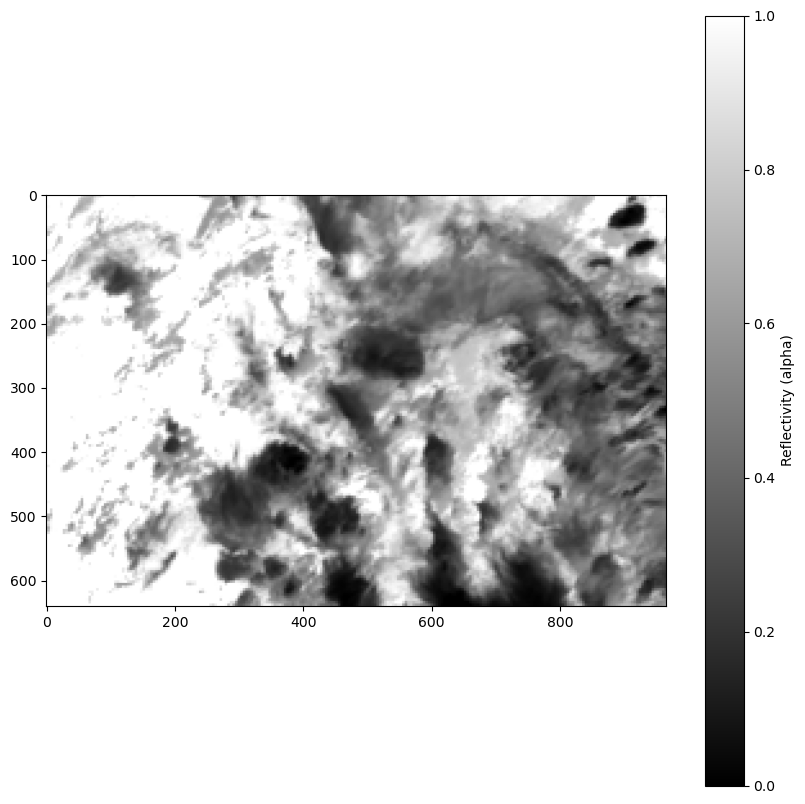

In [ ]:
# plot the reflectivity
plt.figure(figsize=(10, 10))
plt.imshow(final_ds['red'][0, :, :], cmap='gray')
plt.colorbar(label='Reflectivity (alpha)')

In [ ]:
date = '20230204'
path = '/storage/cdalden/goes/goes16/'
file = f'goes16_C02_colorado_{date}.zarr'
ds_C02 = xr.open_dataset(path+'channel02/'+file)

ds_C02

/home/cdalden/miniforge3/envs/goes_old/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


<xarray.Dataset> Size: 2GB
Dimensions:                                           (t: 286,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       number_of_time_bounds: 2,
                                                       num_star_looks: 24,
                                                       y: 640, x: 966)
Coordinates:
  * t                                                 (t) datetime64[ns] 2kB ...
    band_wavelength                                   (band) float32 4B ...
    band_wavelength_star_look                         (num_star_looks) float32 96B ...
    y_image                                           float32 4B ...
    t_star_look                                       (num_star_looks) datetime64[ns] 192B ...
  * y                                                 (y) float64 5kB 0.1092 ...
    x_image                                           float32 4B ...
  * x                                                 (x) float64 8kB -0.0746...
    band_id                                           (band) int8 1B ...
Dimensions without coordinates: number_of_image_bounds, band,
                                number_of_time_bounds, num_star_looks
Data variables: (12/37)
    x_image_bounds                                    (t, number_of_image_bounds) float32 2kB ...
    time_bounds                                       (t, number_of_time_bounds) datetime64[ns] 5kB ...
    saturated_pixel_count                             (t) float64 2kB ...
    geospatial_lat_lon_extent                         (t) float32 1kB ...
    channel_integration_time                          (t) float64 2kB ...
    kappa0                                            (t) float32 1kB ...
    ...                                                ...
    channel_gain_field                                (t) float64 2kB ...
    y_image_bounds                                    (t, number_of_image_bounds) float32 2kB ...
    min_radiance_value_of_valid_pixels                (t) float32 1kB ...
    undersaturated_pixel_count                        (t) float64 2kB ...
    percent_uncorrectable_L0_errors                   (t) float32 1kB ...
    DQF                                               (t, y, x) float32 707MB ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2023-02-04T00:03:57.4Z
    time_coverage_start:       2023-02-04T00:01:17.6Z
    time_coverage_end:         2023-02-04T00:03:54.9Z
    LUT_Filenames:             SpaceLookParams(FM1A_ADR1270_PR_09_08_36)-7190...
    id:                        53d8a0c2-fba0-4183-99a9-b3423eb72c06

## Testing one stop shop zarr to combo rgb

In [3]:
import utils
import os
import xarray as xr
import gc
import warnings

warnings.filterwarnings("ignore")

In [14]:
def goes_nc_to_zarr(in_dir, channels, startday, endday, month, year, location='washington', goes_model='goes17', surprise=False):
    """
    Convert multiple NetCDF files from a directory to a single Zarr file.
    Parameters
    ----------
    in_dir : str
        Input directory containing NetCDF files.
    channels : list
        List of channels to process (e.g., ['C13', 'C02', 'C05']).
    startday : int
        Starting day of the month for processing.
    endday : int
        Ending day of the month for processing.
    month : int
        Month of the data to process.
    year : int
        Year of the data to process.
    location : str
        Location identifier (e.g., 'washington').
    goes_model : str
        GOES satellite model (e.g., 'goes17').
    surprise : bool
        If True, print fun messages during processing.

    Example usage:
    >>> goes_nc_to_zarr('/storage/cdalden/goes/washington/', ['C13', 'C02', 'C05'], 
                        1, 2, 8, 2022, 'washington', 'goes17')
    """ 

    # if no date range is specified, run for full month
    if not startday:
        startday = 1
    if not endday:
        endday = 31

    # this is adds 0 to single digit days of the months
    # GOES sub dirs don't have it but it is needed for the rest of my processing
    for day in range(startday,endday+1):
        day_of_month = str(day)
        if day<10:
            out_day_of_month = '0' + day_of_month
        else:
            out_day_of_month = day_of_month
        print(f'Starting {str(month)}/{day_of_month}')
        
        # Directory containing the NetCDF files
        nc_dir = in_dir + f'{goes_model}/{year}/{month}/{day_of_month}/'
        # Ensure the directory exists
        print(f'Looking for NetCDF files in {nc_dir}')

        # Check if the directory exists
        if not os.path.exists(nc_dir):
            print(f'Directory {nc_dir} does not exist. Skipping...')
            continue

        # count number of files in nc_dir
        num_files = len([f for root, dirs, files in os.walk(nc_dir) for f in files if f.endswith('.nc')])
        expected_num_files = len(channels)*288  # 288 files per channel per day
        if num_files != expected_num_files:
            print(f'WARNING: {num_files} files found in {nc_dir}, expected {expected_num_files}. Skipping...')
            continue

        # loop through all needed channels
        for channel in channels:
            out_name = f'{str(goes_model)}_{channel}_{location}_{str(year)}0{str(month)}{out_day_of_month}.zarr'
            print(f'Processing {out_name}...')
            
            # Recursively list all NetCDF files in the directory and subdirectories
            nc_files = []
            for root, dirs, files in os.walk(nc_dir):
                for file in files:
                    # print(file)
                    if file.endswith('.nc') and channel in file:
                        nc_files.append(os.path.join(root, file))

            # Open multiple NetCDF files as a list of datasets
            datasets = [xr.open_dataset(f) for f in nc_files]

            # Concatenate datasets along the 't' coordinate
            combined_ds = xr.concat(datasets, dim='t')

            # Save the combined dataset to a Zarr file
            out_name = out_name
            combined_ds.to_zarr(in_dir+f'{goes_model}/{channel}/'+out_name)

            # Force garbage collection to free memory
            gc.collect()
            if surprise:
                print('Beep beep, here comes the garbage truck! 🚛')
            print(f'Finished')
            if surprise:
                print('🛰️')

In [2]:
in_dir = f'/storage/cdalden/goes/washington/'
import utils
utils.goes_nc_to_zarr(in_dir, ['C13', 'C02', 'C05'], 5, 5, 8, 2022, 'washington', 'goes17', surprise=True)

Starting 8/5
Looking for NetCDF files in /storage/cdalden/goes/washington/goes17/2022/8/5/
Processing goes17_C13_washington_20220805.zarr...


Beep beep, here comes the garbage truck! 🚛
Finished
🛰️
Processing goes17_C02_washington_20220805.zarr...
Beep beep, here comes the garbage truck! 🚛
Finished
🛰️
Processing goes17_C05_washington_20220805.zarr...
Beep beep, here comes the garbage truck! 🚛
Finished
🛰️


In [1]:
in_dir = f'/storage/cdalden/goes/washington/goes17/'
date = '20220802'
goes = 'goes17'
import utils
utils.goes_rad_to_rgb(in_dir, date, goes, location='washington')